In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
import time
import os
import sys

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath('../Data'))

import queries

## Get Data

In [2]:
server = 'VT3'
schema = 'WCS01600'
features = queries.get_profit_by_month(server, schema)
features.head()

TYEAR  TMON        PROFIT
0  2016.0   1.0  3.161099e+06
1  2016.0   2.0  3.504541e+06
2  2016.0   3.0  4.217011e+06
3  2016.0   4.0  4.019068e+06
4  2016.0   5.0  5.117128e+06

<AxesSubplot:>

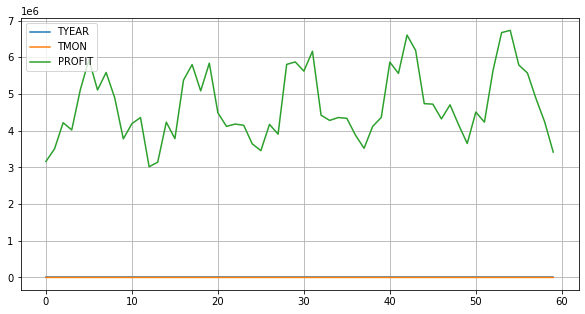

In [5]:
features.plot(grid=True, layout=(49, 1), figsize=(10, 5))

## Feature Importance

<AxesSubplot:>

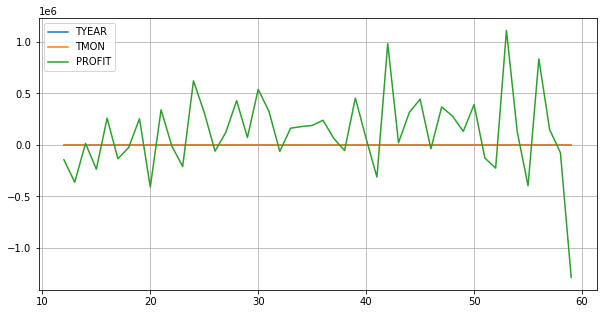

In [7]:
# Remove seasonality to make dataset stationary
# Done to explore other systematic signals
differenced = features.diff(12)[12:]
differenced.plot(grid=True, layout=(49, 1), figsize=(10, 5))


C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:672: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:672: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


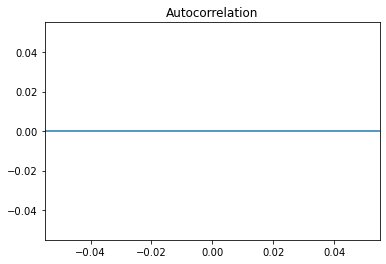

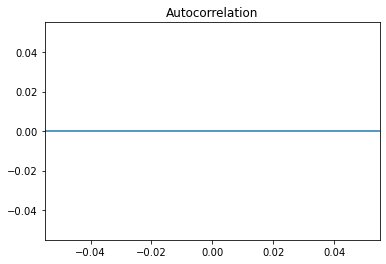

In [8]:
# Autocorrelation plotting (correlogram)
for var in differenced.columns:
    plot_acf(differenced[var])
    plt.show()

In [12]:
# Creating columns of shifted observations (lag values)
cols = differenced.columns.delete([0,1])
lags = range(12, 0, -1)

differenced_lag = differenced.assign(**{
    '{} (t-{})'.format(col, t): differenced[col].shift(t)
    for t in lags
    for col in cols
})[12:]

print(differenced_lag)


    TYEAR  TMON        PROFIT  PROFIT (t-12)  PROFIT (t-11)  PROFIT (t-10)  \
24    1.0   0.0  6.223480e+05   -144291.3086   -362933.5269     14385.8484   
25    1.0   0.0  3.147053e+05   -362933.5269     14385.8484   -236024.1187   
26    1.0   0.0 -6.081372e+04     14385.8484   -236024.1187    258989.2151   
27    1.0   0.0  1.220710e+05   -236024.1187    258989.2151   -134863.2612   
28    1.0   0.0  4.300699e+05    258989.2151   -134863.2612    -25603.5547   
29    1.0   0.0  7.154128e+04   -134863.2612    -25603.5547    254317.6582   
30    1.0   0.0  5.390149e+05    -25603.5547    254317.6582   -409636.9593   
31    1.0   0.0  3.246477e+05    254317.6582   -409636.9593    340748.0784   
32    1.0   0.0 -6.348344e+04   -409636.9593    340748.0784    -11508.1724   
33    1.0   0.0  1.621368e+05    340748.0784    -11508.1724   -210728.7737   
34    1.0   0.0  1.778639e+05    -11508.1724   -210728.7737    622348.0060   
35    1.0   0.0  1.886777e+05   -210728.7737    622348.0060    3

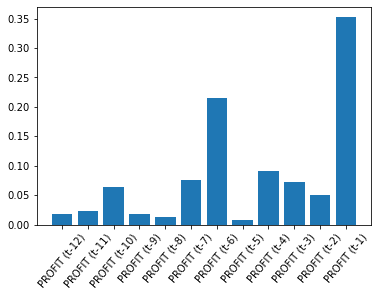

<Figure size 2880x4320 with 0 Axes>

In [18]:
# Feature importance score for each feature and subsequent lagged features
X = differenced_lag.filter(regex = rf"PROFIT.*-.*")
Y = differenced_lag.filter(regex = rf"PROFIT((?!-).)*$")

model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, np.ravel(Y))

names = X.columns
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names, rotation=45)
plt.figure(figsize=(40, 60))
plt.show()

C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
C:\Users\Luke.Beatty\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expect

Selected Features:
PROFIT (t-6)
PROFIT (t-3)
PROFIT (t-1)


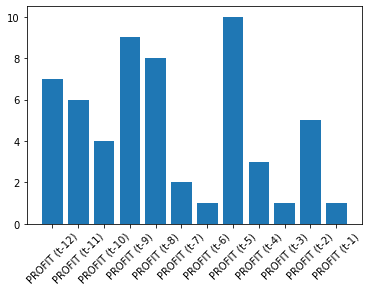

In [25]:
# Feature selection of lag variables
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=3)
fit = rfe.fit(X, Y)
print('Selected Features:')
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names, rotation=45)
plt.show()

## Model Training